Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import json
from google.colab import files


Image Transformations

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])


Upload Dataset

In [3]:
from google.colab import files
files.upload()

Saving traffic_dataset.zip to traffic_dataset.zip


In [4]:
!unzip traffic_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: DATA/16/016_1_0055.png  
  inflating: DATA/16/016_1_0056.png  
  inflating: DATA/16/016_1_0057.png  
  inflating: DATA/16/016_1_0058.png  
  inflating: DATA/16/016_1_0059.png  
  inflating: DATA/16/016_1_0060.png  
  inflating: DATA/16/016_1_0061.png  
  inflating: DATA/16/016_1_0062.png  
  inflating: DATA/16/016_1_0063.png  
  inflating: DATA/16/016_1_0064.png  
  inflating: DATA/16/016_1_0065.png  
  inflating: DATA/16/016_1_0066.png  
  inflating: DATA/16/016_1_0067.png  
  inflating: DATA/16/016_1_0068.png  
  inflating: DATA/16/016_1_0069.png  
  inflating: DATA/16/016_1_0070.png  
  inflating: DATA/17/017_0001.png    
  inflating: DATA/17/017_0001_j.png  
  inflating: DATA/17/017_0002.png    
  inflating: DATA/17/017_0002_j.png  
  inflating: DATA/17/017_0003.png    
  inflating: DATA/17/017_0003_j.png  
  inflating: DATA/17/017_0004.png    
  inflating: DATA/17/017_0004_j.png  
  inflating: DATA/17/017_0005.png    

Load Label Names

In [5]:
labels_df = pd.read_csv("labels.csv")

Load dataset

In [6]:
train_data = datasets.ImageFolder("DATA", transform=transform)
test_data = datasets.ImageFolder("TEST", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

num_classes = len(train_data.classes)
print("Classes:", num_classes)
print(train_data.classes)


Classes: 52
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '6', '7', '8', '9']


In [7]:
class_id_to_name = {}

for idx, folder in enumerate(train_data.classes):
    class_id = int(folder)
    class_name = labels_df.loc[
        labels_df.ClassId == class_id, "Name"
    ].values[0]
    class_id_to_name[idx] = class_name


In [8]:
with open("class_id_to_name.json", "w") as f:
    json.dump(class_id_to_name, f)

files.download("class_id_to_name.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CNN model

In [9]:
class BetterCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


training setup

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BetterCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


Train the Model

In [11]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []

epochs = 25

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {epoch_loss:.4f}  Accuracy: {epoch_acc:.2f}%")


Epoch [1/25]  Loss: 2.3872  Accuracy: 39.52%
Epoch [2/25]  Loss: 1.1548  Accuracy: 68.92%
Epoch [3/25]  Loss: 0.7226  Accuracy: 80.71%
Epoch [4/25]  Loss: 0.5089  Accuracy: 85.54%
Epoch [5/25]  Loss: 0.3625  Accuracy: 90.23%
Epoch [6/25]  Loss: 0.2758  Accuracy: 92.47%
Epoch [7/25]  Loss: 0.2147  Accuracy: 94.11%
Epoch [8/25]  Loss: 0.1698  Accuracy: 95.48%
Epoch [9/25]  Loss: 0.1385  Accuracy: 96.29%
Epoch [10/25]  Loss: 0.1199  Accuracy: 96.66%
Epoch [11/25]  Loss: 0.1128  Accuracy: 96.92%
Epoch [12/25]  Loss: 0.0922  Accuracy: 97.33%
Epoch [13/25]  Loss: 0.0932  Accuracy: 97.22%
Epoch [14/25]  Loss: 0.0829  Accuracy: 97.57%
Epoch [15/25]  Loss: 0.0786  Accuracy: 97.66%
Epoch [16/25]  Loss: 0.0769  Accuracy: 97.66%
Epoch [17/25]  Loss: 0.0738  Accuracy: 97.80%
Epoch [18/25]  Loss: 0.0615  Accuracy: 98.21%
Epoch [19/25]  Loss: 0.0590  Accuracy: 98.40%
Epoch [20/25]  Loss: 0.0553  Accuracy: 98.31%
Epoch [21/25]  Loss: 0.0626  Accuracy: 98.08%
Epoch [22/25]  Loss: 0.0540  Accuracy: 98.1

Plot Accuracy vs Epochs

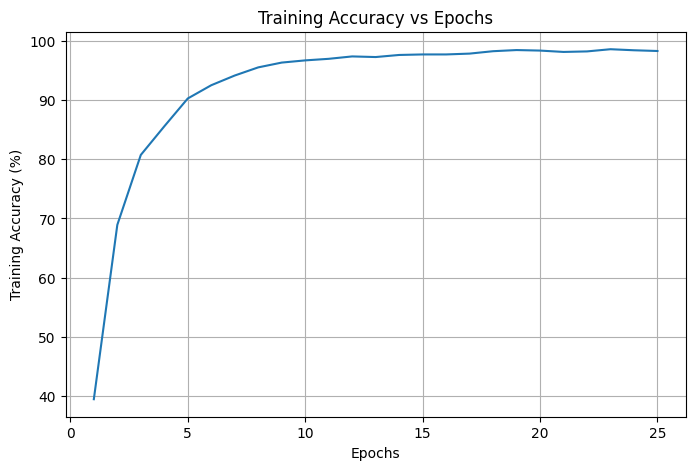

In [12]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy (%)")
plt.title("Training Accuracy vs Epochs")
plt.grid(True)
plt.show()


Plot Loss vs Epochs

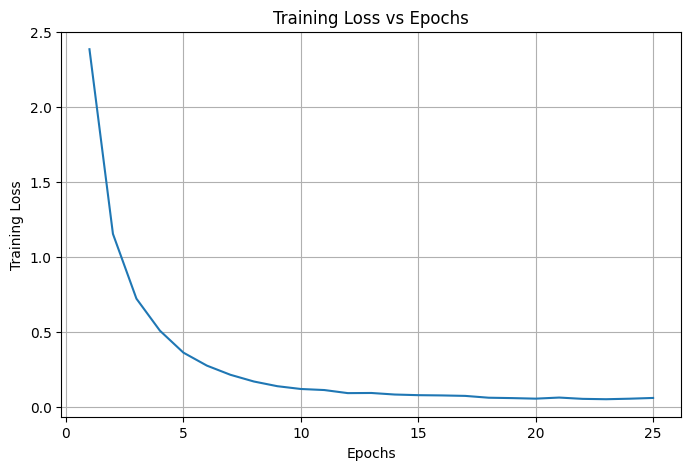

In [13]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()


Test the Model

In [14]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy:", 100 * correct / total)


Accuracy: 89.83833718244804


Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [16]:
cm = confusion_matrix(all_labels, all_preds)


Plot Confusion Matrix

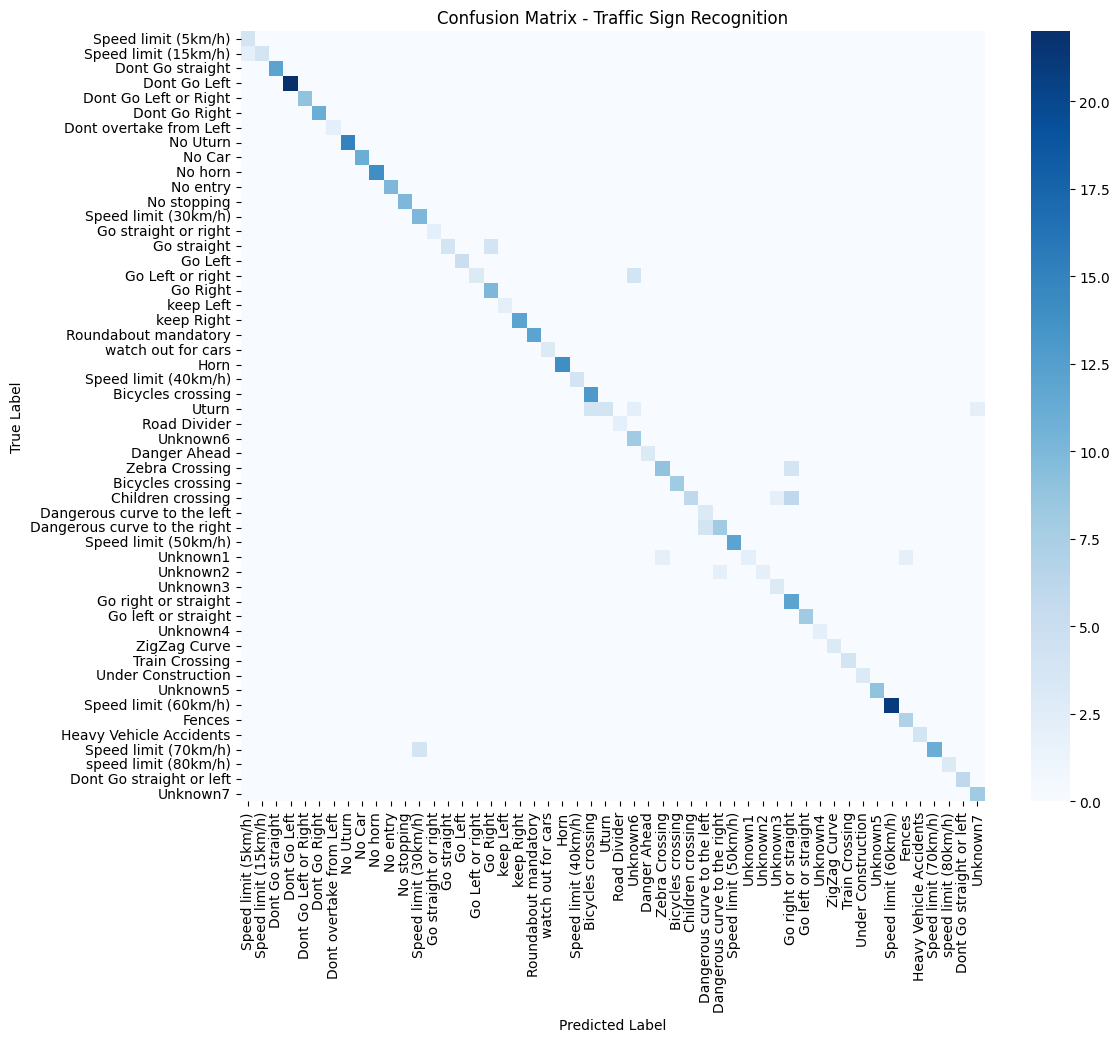

In [18]:
plt.figure(figsize=(12,10))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=[class_id_to_name[i] for i in range(len(class_id_to_name))],
    yticklabels=[class_id_to_name[i] for i in range(len(class_id_to_name))],
    fmt="d"
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Traffic Sign Recognition")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


Save Model

In [ ]:
torch.save(model.state_dict(), "traffic_sign_model.pth")
files.download("traffic_sign_model.pth")
files.download("labels.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>